In [2]:
using Gen
using Plots
using Pkg
Pkg.activate("myenv")
Pkg.add("ForwardDiff")
using ForwardDiff

  Activating new project at `~/Documents/Courses/CognitiveAI/Slides/Week 7/myenv`
   Resolving package versions...
   Installed LogExpFunctions ─ v0.3.27
    Updating `~/Documents/Courses/CognitiveAI/Slides/Week 7/myenv/Project.toml`
  [f6369f11] + ForwardDiff v0.10.36
    Updating `~/Documents/Courses/CognitiveAI/Slides/Week 7/myenv/Manifest.toml`
  [bbf7d656] + CommonSubexpressions v0.3.0
  [163ba53b] + DiffResults v1.1.0
  [b552c78f] + DiffRules v1.15.1
  [ffbed154] + DocStringExtensions v0.9.3
  [f6369f11] + ForwardDiff v0.10.36
  [92d709cd] + IrrationalConstants v0.2.2
  [692b3bcd] + JLLWrappers v1.5.0
  [2ab3a3ac] + LogExpFunctions v0.3.27
  [1914dd2f] + MacroTools v0.5.13
  [77ba4419] + NaNMath v1.0.2
  [21216c6a] + Preferences v1.4.1
  [276daf66] + SpecialFunctions v2.3.1
  [1e83bf80] + StaticArraysCore v1.4.2
  [efe28fd5] + OpenSpecFun_jll v0.5.5+0
  [0dad84c5] + ArgTools v1.1.1
  [56f22d72] + Artifacts
  [2a0f44e3] + Base64
  [ade2ca70] + Dates
  [f43a241f] + Downloads v1.6.0

In [3]:
f(x) = x^2

f (generic function with 1 method)

In [3]:
ForwardDiff.derivative(f, 1.0)

2.0

In [4]:
ϵ = 0.1
(f(1 + ϵ) - f(1))/ϵ

2.100000000000002

In [5]:
g((x,y)) = x + y + x * y

g (generic function with 1 method)

In [6]:
ForwardDiff.gradient(g, [1, 2])

2-element Vector{Int64}:
 3
 2

In [7]:
begin
    ∂g∂x = (g([1 + ϵ, 2]) - g([1, 2]))/ϵ
    ∂g∂y = (g([1, 2 + ϵ]) - g([1, 2]))/ϵ
    ∇g = [∂g∂x, ∂g∂y]
end

2-element Vector{Float64}:
 3.000000000000007
 2.0000000000000018

## Trainable parameters example

Here is a generative function with a few parameters and a couple of random variables

In [8]:
@gen function model_fixed_params()
    x_mu::Float64 = 1.0
    a::Float64 = 1.5
    b::Float64 = 0.7
    x ~ normal(x_mu, 1.)
    y ~ normal(a * x + b, 1.)
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##model_fixed_params#225", Bool[], false)

In [9]:
function visualize(model)
    xs = zeros(100)::Vector{Float64}
    ys = zeros(100)::Vector{Float64}
    for k in 1:100
        trace = Gen.simulate(model, ())
        xs[k] = trace[:x]
        ys[k] = trace[:y]
    end
    scatter(xs, ys, labels=:none, thickness_scaling=3.5, size=(1600, 1600))
end

visualize (generic function with 1 method)

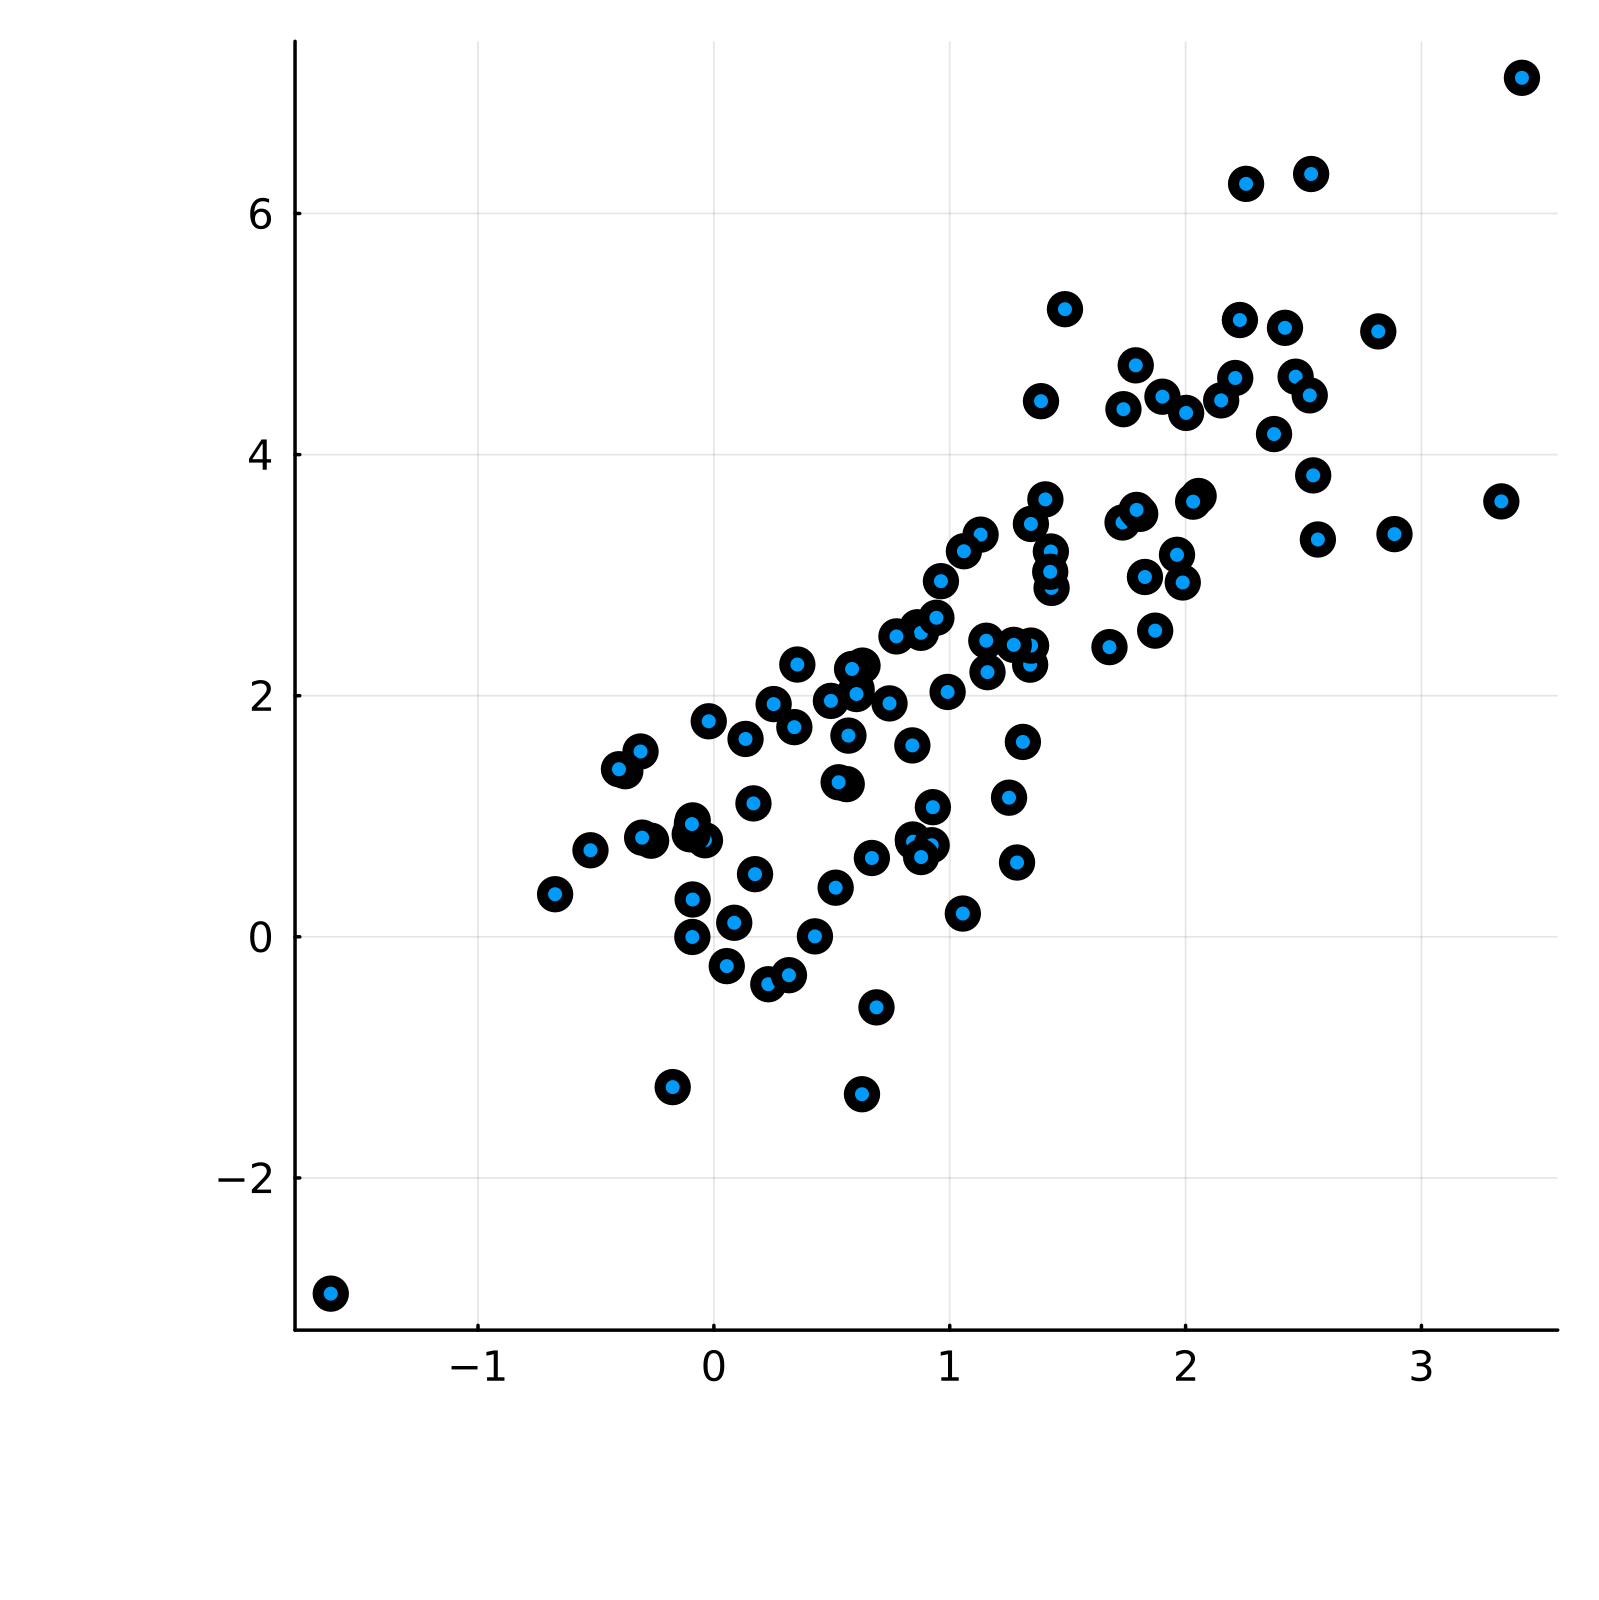

In [10]:
visualize(model_fixed_params)

Let's define a generative model with *trainable* parameters.

In [13]:
@gen function model_trainable()
    @param center::Float64
    @param a::Float64
    @param b::Float64
    x ~ normal(center, 1.)
    y ~ normal(a * x + b, 1.)
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##model_trainable#227", Bool[], false)

## Learning procedure

Learning procedure consists of these steps.

- Initialization of parameters
- Data loader
- Choice of the optimizer
- Training

In [14]:
function data_generator()
    dgp_trace = Gen.simulate(model_fixed_params, ())
    constraints = Gen.choicemap()
    constraints[:x] = dgp_trace[:x]
    constraints[:y] = dgp_trace[:y]
    return ((), constraints)
end

data_generator (generic function with 1 method)

In [46]:
function train_model()
    init_param!(model_trainable, :a, 0.1)
    init_param!(model_trainable, :b, 0.1)
    init_param!(model_trainable, :center, 0.1)
    max_iter = 100
    batch_size = 50
    loss = []
    update = ParamUpdate(FixedStepGradientDescent(0.001), model_trainable)
    for iter=1:max_iter
        objective = 0
        for k in 1:batch_size
            inputs, contraints = data_generator()
            trace, weight = Gen.generate(model_trainable, inputs, contraints)
            objective += weight
            accumulate_param_gradients!(trace)
        end
        push!(loss, objective/batch_size)
        apply!(update)
    end
    return loss
end

train_model (generic function with 2 methods)

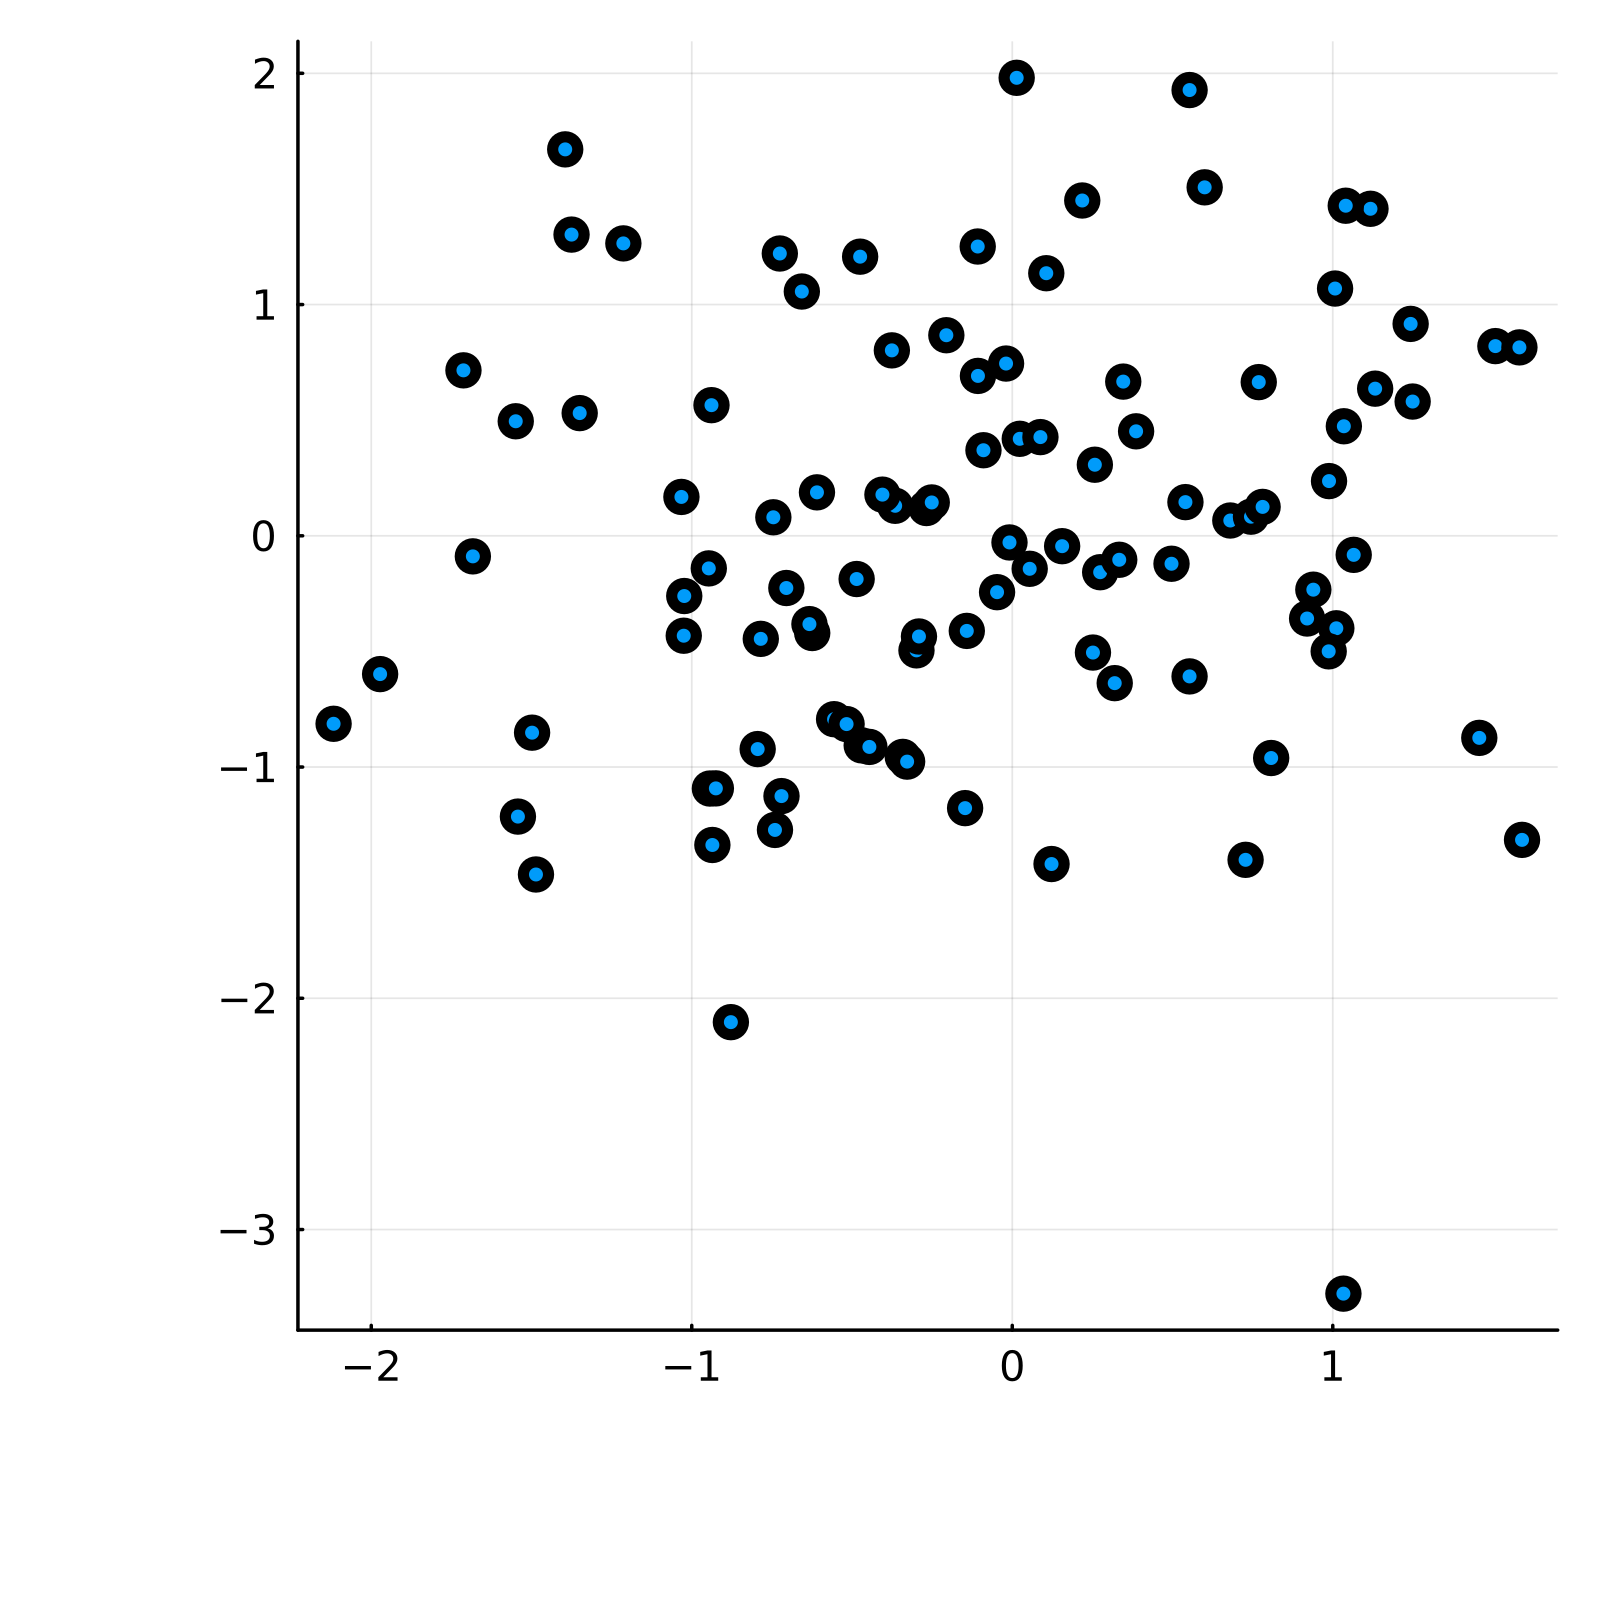

In [44]:
init_param!(model_trainable, :a, 0.1)
init_param!(model_trainable, :b, 0.1)
init_param!(model_trainable, :center, 0.1)
visualize(model_trainable)

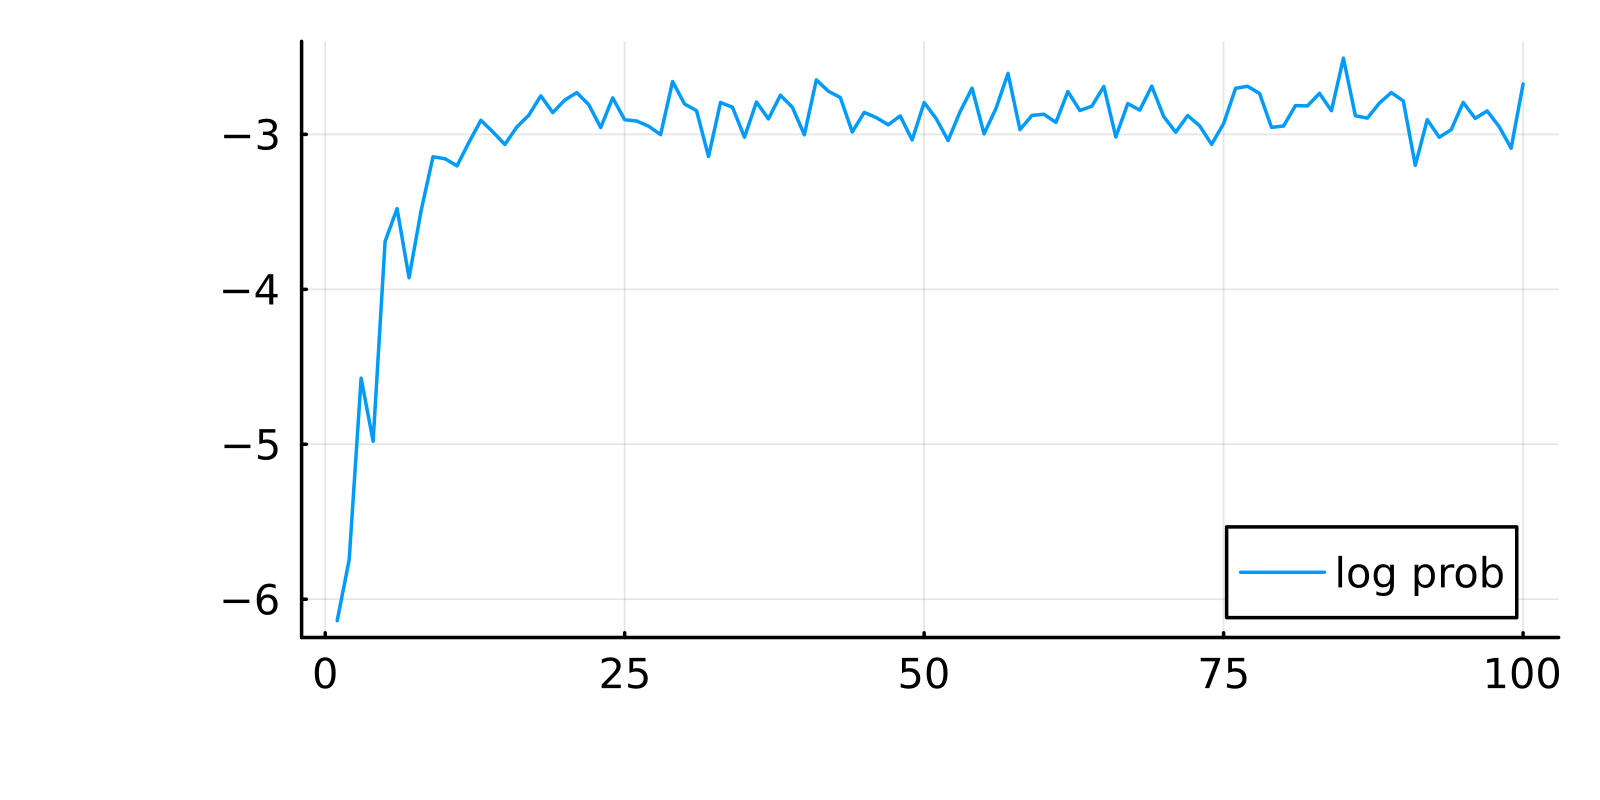

In [47]:
loss = train_model()
plot(loss, labels="log prob", thickness_scaling=3.5, size=(1600, 800))

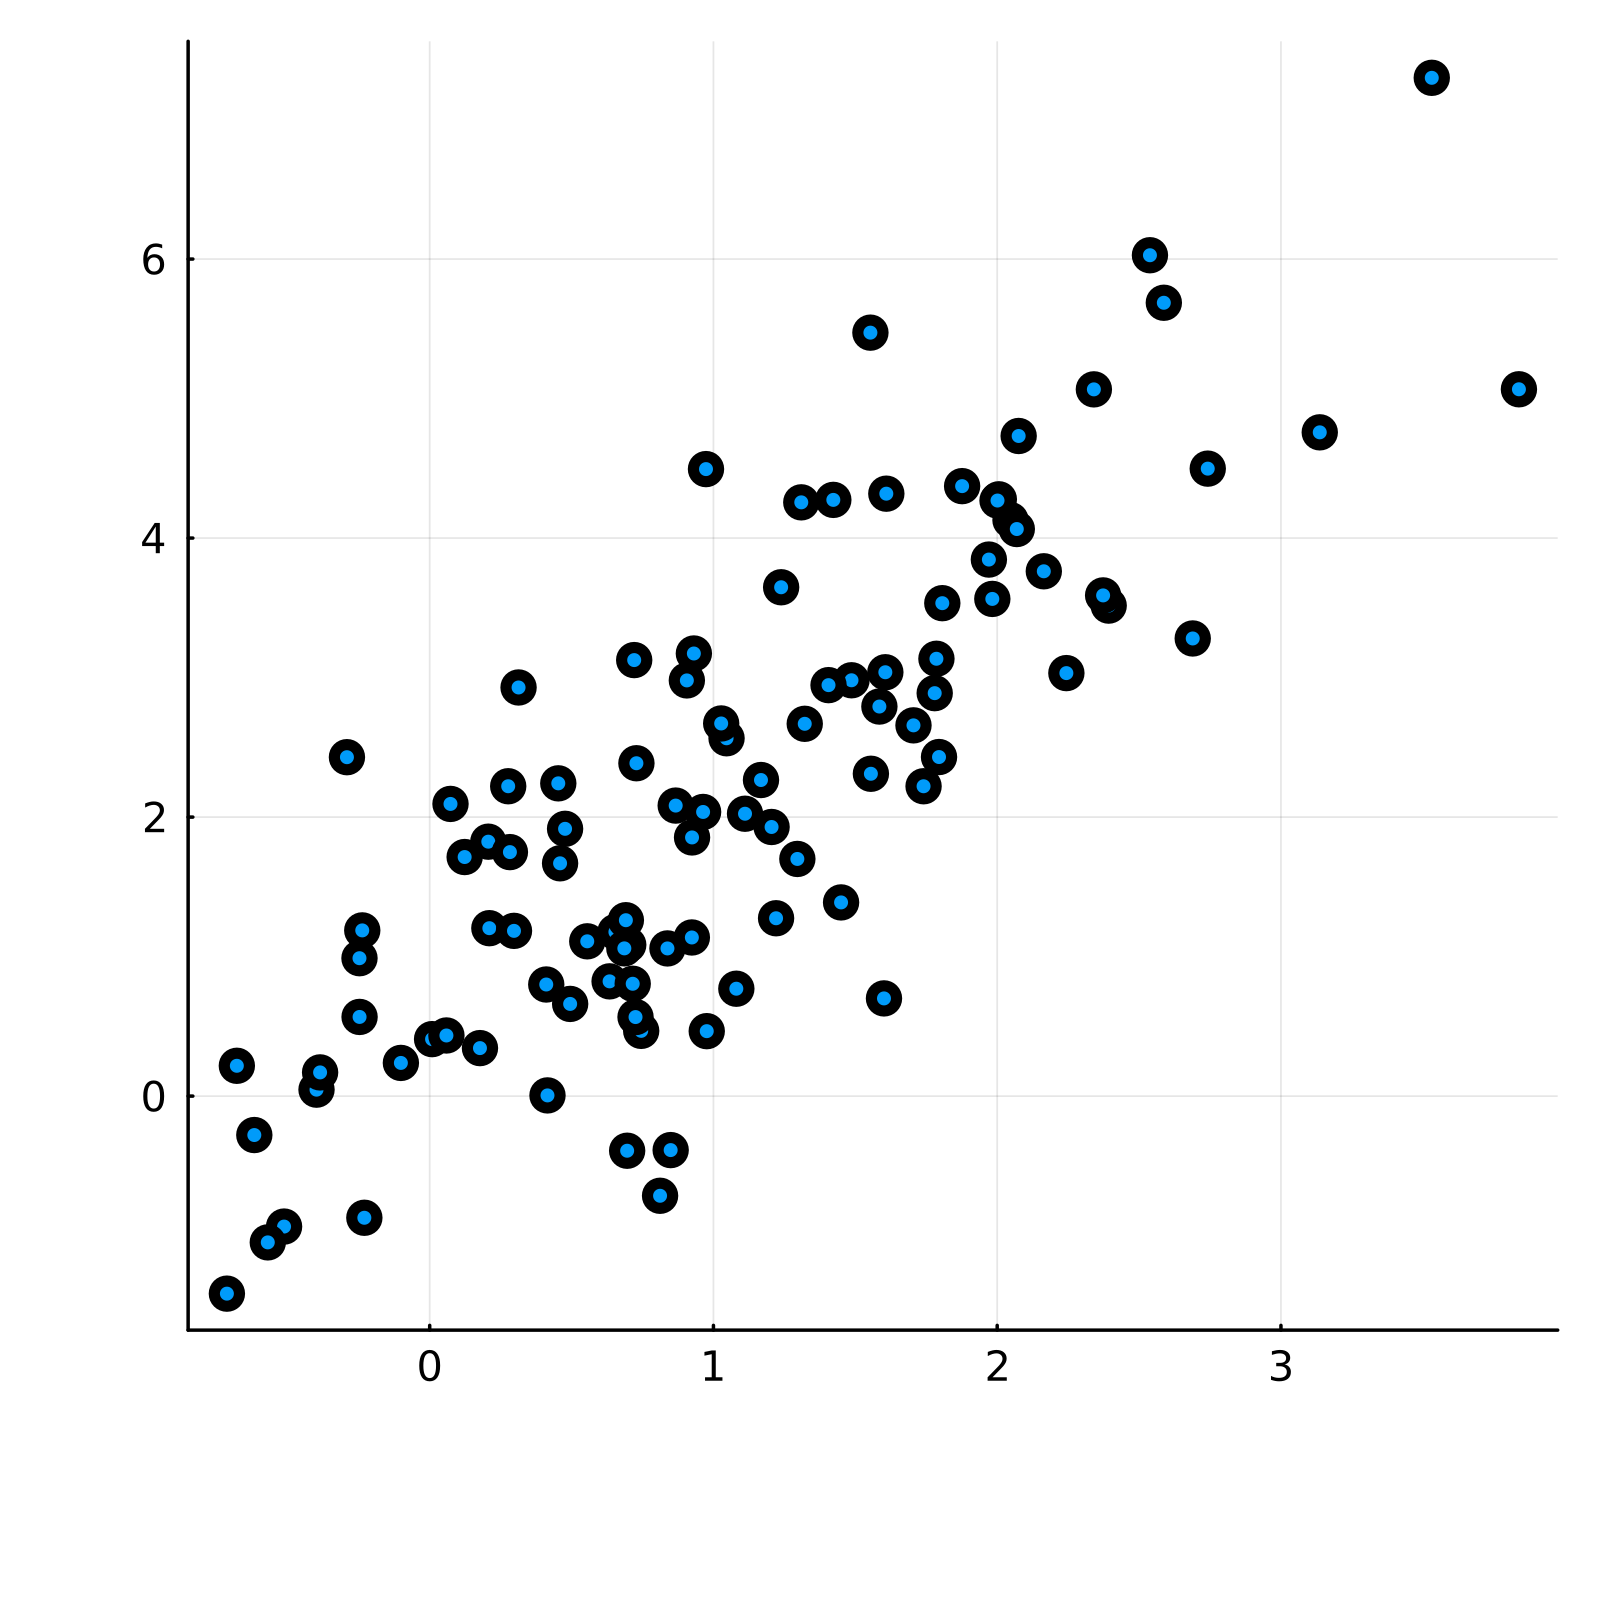

In [24]:
visualize(model_trainable)

A simpler way to write training is to use Gen.train!() function

In [41]:
init_param!(model_trainable, :a, 0.1)
init_param!(model_trainable, :b, 0.1)
init_param!(model_trainable, :center, 0.1)

update = ParamUpdate(FixedStepGradientDescent(0.001), model_trainable)

scores = Gen.train!(model_trainable, data_generator, update,
    num_epoch=100, epoch_size=100, num_minibatch=2, minibatch_size=50, evaluation_size=100, verbose=true);

epoch 1: generating 100 training examples...
epoch 1: training using 2 minibatches of size 50...
epoch 1: evaluating on 100 examples...
epoch 1: est. objective value: 0.0
epoch 2: generating 100 training examples...
epoch 2: training using 2 minibatches of size 50...
epoch 2: evaluating on 100 examples...
epoch 2: est. objective value: 0.0
epoch 3: generating 100 training examples...
epoch 3: training using 2 minibatches of size 50...
epoch 3: evaluating on 100 examples...
epoch 3: est. objective value: 0.0
epoch 4: generating 100 training examples...
epoch 4: training using 2 minibatches of size 50...
epoch 4: evaluating on 100 examples...
epoch 4: est. objective value: 0.0
epoch 5: generating 100 training examples...
epoch 5: training using 2 minibatches of size 50...
epoch 5: evaluating on 100 examples...
epoch 5: est. objective value: 0.0
epoch 6: generating 100 training examples...
epoch 6: training using 2 minibatches of size 50...
epoch 6: evaluating on 100 examples...
epoch 6: 

epoch 64: est. objective value: 0.0
epoch 65: generating 100 training examples...
epoch 65: training using 2 minibatches of size 50...
epoch 65: evaluating on 100 examples...
epoch 65: est. objective value: 0.0
epoch 66: generating 100 training examples...
epoch 66: training using 2 minibatches of size 50...
epoch 66: evaluating on 100 examples...
epoch 66: est. objective value: 0.0
epoch 67: generating 100 training examples...
epoch 67: training using 2 minibatches of size 50...
epoch 67: evaluating on 100 examples...
epoch 67: est. objective value: 0.0
epoch 68: generating 100 training examples...
epoch 68: training using 2 minibatches of size 50...
epoch 68: evaluating on 100 examples...
epoch 68: est. objective value: 0.0
epoch 69: generating 100 training examples...
epoch 69: training using 2 minibatches of size 50...
epoch 69: evaluating on 100 examples...
epoch 69: est. objective value: 0.0
epoch 70: generating 100 training examples...
epoch 70: training using 2 minibatches of s

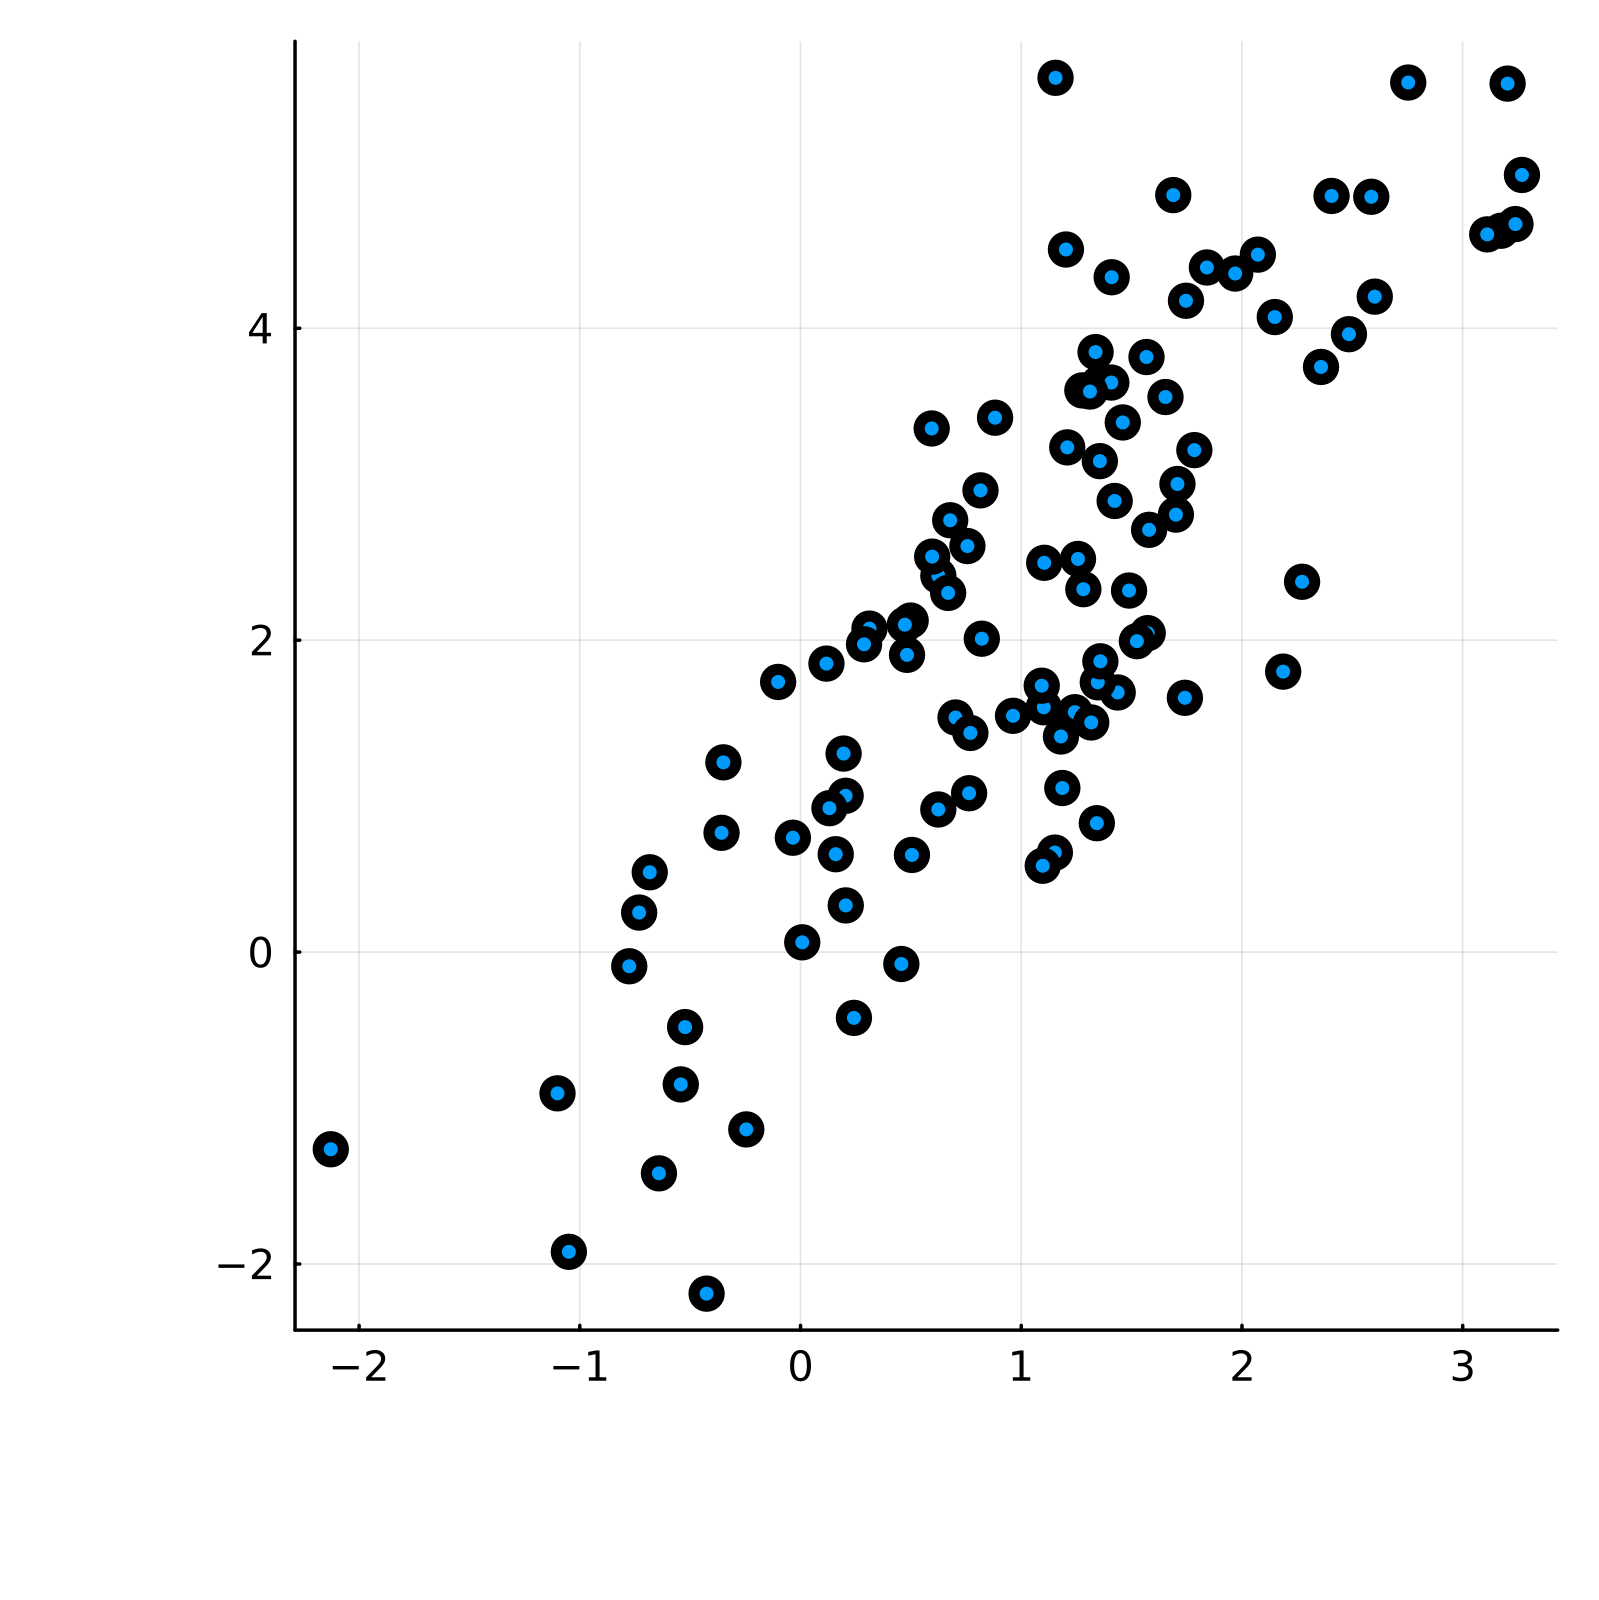

In [48]:
visualize(model_trainable)